# Land Cover Classification

## Part 2: Classfication

<hr style="border:1px solid gray"> </hr>

## Introduction

A Land Cover map can be used to map the various types of land cover (streams, built-up) and also the forest cover (evergreen forest, mixed forest and invasive plant species). There are three invasive plant species seen within Betampona Nature Reserve (BNR): Madagascar Cardamom, Molucca Raspberry and Strawberry Guava. 
BNR is located in northeastern Madagascar and was designated a strict Nature Reserve in 1927.

The table below lists the land cover classes along with the detailed descriptions

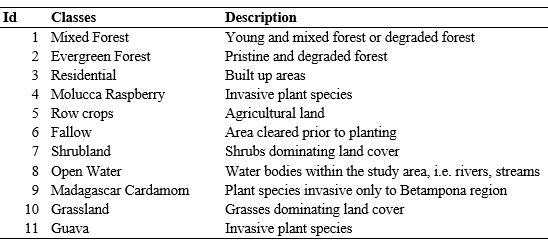

## 0. Data

### 0.1. Imagery Data

The imagery used for this lab is the WorldView-3 (WV-3) imagery collected on February 19th 2019 over Betampona, Madagascar. The imagery was radiometrically and atmospherically corrected.

The below image shows the spectral bands that is available with WV-3

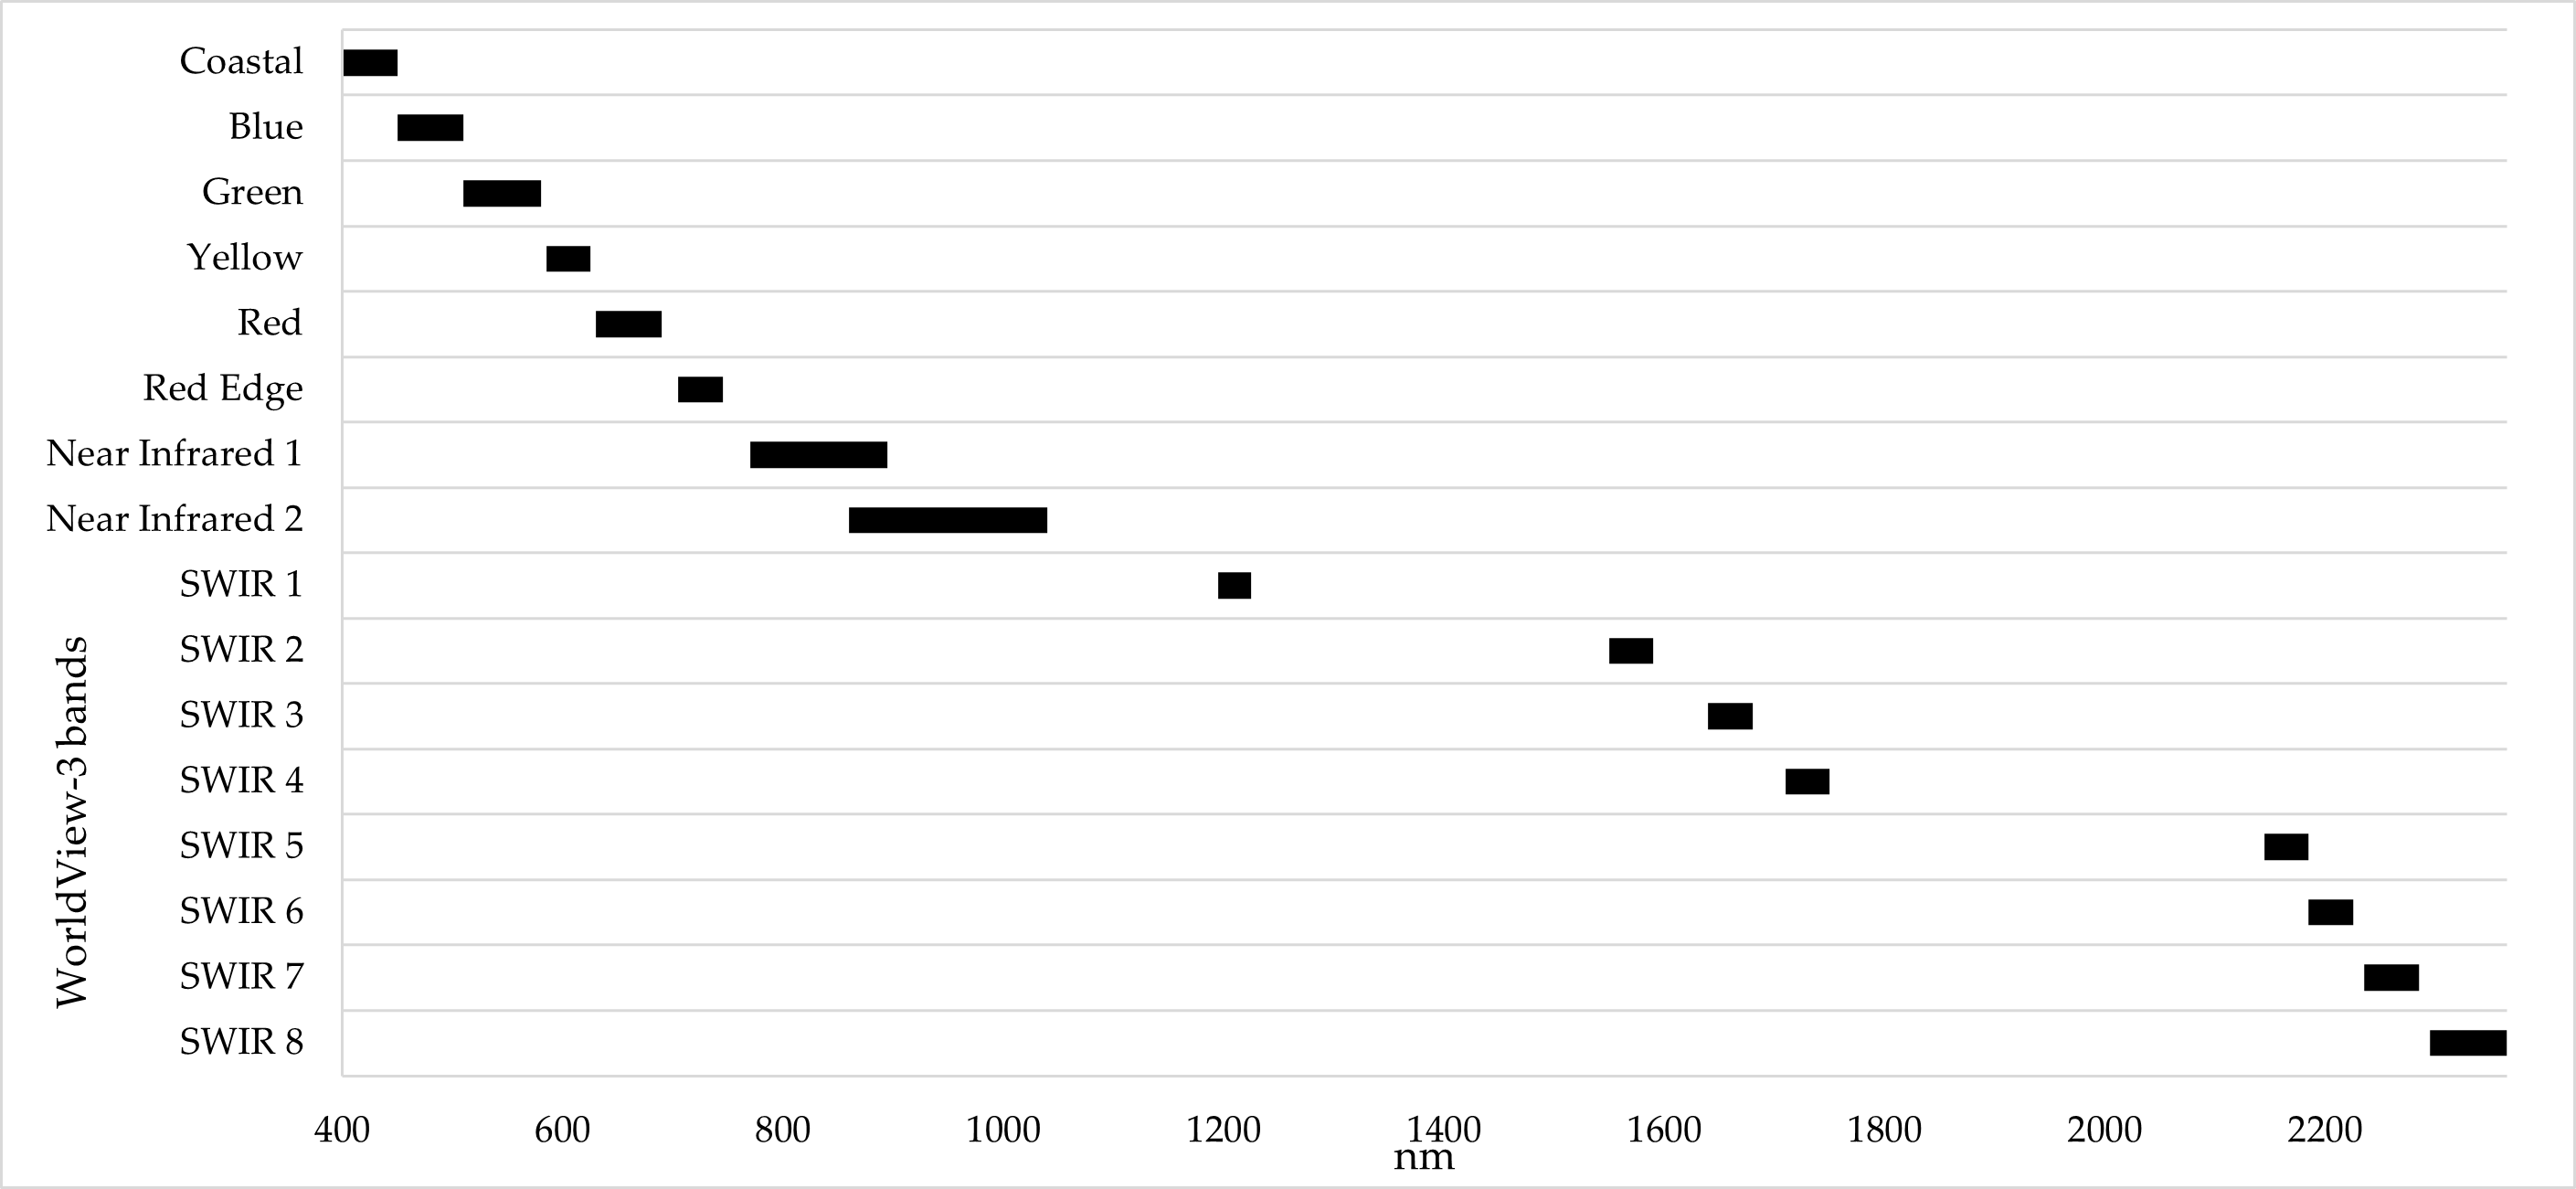

Data included with this lab
* data_img.tif: 16 band WV-3 image .tif file
* Bet_LandCover_2020.tif: label image

### 0.2. Classification Methods

To create the land cover map, we will use pixel based classification methods 
1. Support Vector Machine (SVM)
2. Random Forest (RF)
3. Deep Neural Network (DNN)
4. Fully Convolutional Network (FCNN)              
      4.1 U-Net               

Support Vector Machine and Random Forest are typical machine learning models and are used for comparison. Deep Neural Network is a multilayer perceptron network, which is also used for comparison with deep learning models. 

An FCNN performs pixel-wise semantic segmentation. It performs pixel-wise classification, by creating semantic objects through a fully convolutional architecture. 

Thus, a FCNN would outperform other pixel based methods, and produce and automated, end-to-end land cover map. 

### 0.3. Importing Data

In [ ]:
# change base directory 

import os
path= r'./patch-one-hot' # change base dir
path= r'./pixel-level' 
path= r'./pixel-one-hot'

os.chdir(path)

In [2]:
# import the data (pixel-level for SVM, RF, DNN; patch-one-hot-encoded for U-Net)
import numpy as np


# change base directory 

import os
path= r'./patch-one-hot' # change base dir
path= r'./pixel-level' 
path= r'./pixel-one-hot'

os.chdir(path)
x_train = np.load('./X_train.npy')
x_test = np.load('./X_test.npy')
y_train = np.load('./y_train.npy')
y_test = np.load('./y_test.npy')

In [3]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(720896, 16)
(720896, 11)
(196608, 16)
(196608, 11)


## 1. U-Net

In [ ]:
!pip install rasterio

In [ ]:
!pip install geopandas

In [61]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import rasterio
import pandas as pd

from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dense, BatchNormalization, 
                                     Flatten ,Activation, Dropout, Concatenate)
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from keras.models import load_model
from tensorflow.keras.metrics import MeanIoU
from tensorflow import keras 
from tensorflow.keras.models import Model 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score

In [8]:
input_height= 256
input_width = 256
n_classes= 11
n_bands= 16

In [ ]:
# import the data (pixel-level for SVM, RF, DNN; patch-one-hot-encoded for U-Net)
import numpy as np


# change base directory 

import os
path= r'./patch-one-hot' # change base dir
path= r'./pixel-level' 
path= r'./pixel-one-hot'

os.chdir(path)
x_train = np.load('./X_train.npy')
x_test = np.load('./X_test.npy')
y_train = np.load('./y_train.npy')
y_test = np.load('./y_test.npy')

#### 1.1. Defining Model

In [240]:
img_input = Input(shape=(input_height,input_width , n_bands ))

# encoder layers
# block 1
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(img_input) # in the original code, a 'valid' padding is applied all throughout 
conv1 = Dropout(0.2)(conv1)
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1) 
pool1 = MaxPooling2D((2, 2), strides=2)(conv1)

# block 2
conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Dropout(0.2)(conv2)
conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2) 
pool2 = MaxPooling2D((2, 2), strides=2)(conv2) 

# block 3
conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Dropout(0.2)(conv3)
conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) 
pool3 = MaxPooling2D((2, 2), strides=2)(conv3) 

# block 4
conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Dropout(0.2)(conv4)
conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4) 
pool4 = MaxPooling2D((2, 2), strides=2)(conv4) 

# bottleneck
conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Dropout(0.2)(conv5)
conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)


# decoder layers
# block _4
#conv4= Cropping2D(cropping=((4, 4), (4, 4)))(conv4)
up_4 = Concatenate(axis=-1)([UpSampling2D((2, 2))(conv5), conv4])
#up_4 = UpSampling2D((2, 2))(conv5)
conv_4 = Conv2D(512, (3, 3), activation='relu', padding='same')(up_4)
conv_4 = Dropout(0.2)(conv_4)
conv_4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv_4) 

# block _3
#conv3= Cropping2D(cropping=((4, 4), (4, 4)))(conv3)
up_3 = Concatenate(axis=-1)([UpSampling2D((2, 2))(conv_4), conv3])
#up_3= UpSampling2D((2, 2))(conv_4)
conv_3 = Conv2D(256, (3, 3), activation='relu', padding='same')(up_3)
conv_3 = Dropout(0.2)(conv_3)
conv_3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv_3)


# block -2
#conv2= Cropping2D(cropping=((12, 12), (12, 12)))(conv2)
up_2 = Concatenate(axis=-1)([UpSampling2D((2, 2))(conv_3), conv2])
#up_2= UpSampling2D((2, 2))(conv_3)
conv_2 = Conv2D(128, (3, 3), activation='relu', padding='same')(up_2)
conv_2 = Dropout(0.2)(conv_2)
conv_2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv_2) 

# block -1
#conv1= Cropping2D(cropping=((28, 28), (28, 28)))(conv1)
up_1 = Concatenate(axis=-1)([UpSampling2D((2, 2))(conv_2), conv1]) 
#up_1= UpSampling2D((2, 2))(conv_2)
conv_1 = Conv2D(32, (3, 3), activation='relu', padding='same')(up_1)
conv_1 = Dropout(0.2)(conv_1)
conv_1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv_1)

out = Conv2D( n_classes, (1,1) , padding='same')(conv_1) # changed from (1,1) to (3,3)
out = Activation('softmax')(out)

model=Model(img_input, out)

In [101]:
print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 16 0                                            
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 256, 256, 32) 4640        input_5[0][0]                    
__________________________________________________________________________________________________
dropout_20 (Dropout)            (None, 256, 256, 32) 0           conv2d_44[0][0]                  
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, 256, 256, 32) 9248        dropout_20[0][0]                 
____________________________________________________________________________________________

#### 1.2. Compiling & Fitting model

In [241]:
# compile the model

model.compile(optimizer='Adam',
              loss=['categorical_crossentropy'], 
              metrics= ['categorical_accuracy']
             )

In [ ]:
# fit the model
history = model.fit(x_train, y_train, batch_size=64, epochs=200, validation_split=0.3)#, verbose=1)

#### 1.3. Visualizing Loss Curves

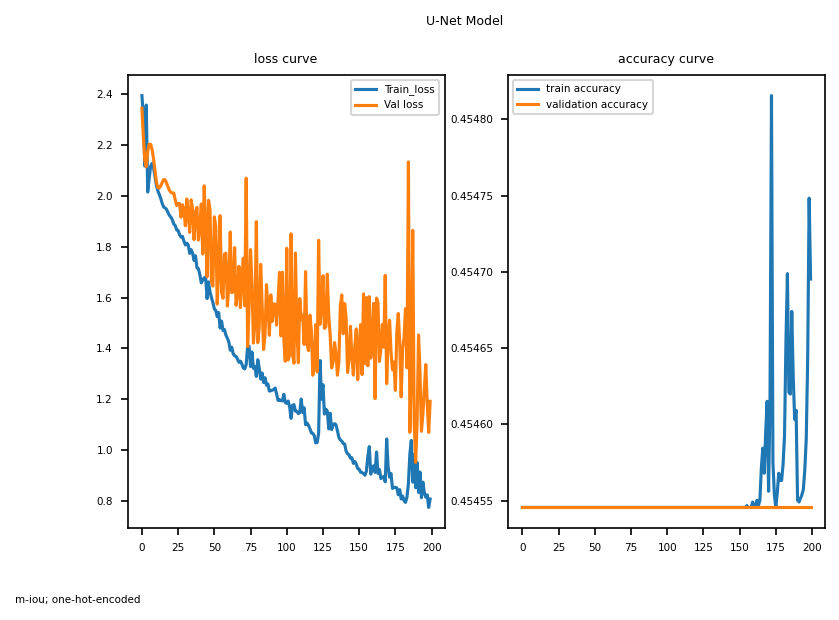

In [108]:
# for m-iou
fig, ax= plt.subplots(1,2, dpi=150)
ax[0].plot(history.history['loss'], label='Train_loss')
ax[0].plot(history.history['val_loss'], label='Val loss')
ax[0].legend()
ax[0].set_title('loss curve')

ax[1].plot(history.history['categorical_accuracy'], label='train accuracy')
ax[1].plot(history.history['val_categorical_accuracy'], label='validation accuracy')
ax[1].legend()
ax[1].set_title('accuracy curve')

fig.suptitle('U-Net Model')
plt.show()

#### 1.4. Hyperparamter Optimization 

In [ ]:
batch_list= [2, 4, 8, 16, 32]
epoch_list=[100,200, 500]


In [ ]:
# compile the model

model.compile(optimizer='Adam',
              loss=['categorical_crossentropy'], 
              metrics= ['categorical_accuracy']
             )

In [ ]:
train_acc= []
train_kap= []
test_acc= []
test_kap= []
batch= []
epoch= []

for b in batch_list:
  for e in epoch_list:
    # fit the model
    print(b,e)
    history = model.fit(x_train, y_train, batch_size=b, epochs=e, validation_split=0.2, verbose=0)

    # predictions for training data
    y_pred_train_= model.predict(x_train)
    y_pred_train = np.argmax(y_pred_train_, axis= -1)

    # reverse one-hot encoding for y_train 
    y_train_=np.argmax(y_train, axis=-1)

    # predictions for testing data 
    y_pred_test_= model.predict(x_test)
    y_pred_test=np.argmax(y_pred_test_, axis=-1) # (not one-hot encoded)

    # reverse one-hot encoding for y_test_
    y_test_= np.argmax(y_test, axis=-1)

    # Classification Model Validation

    # reshape is needed to change from a 2D array to a 1D array
    training_acc = accuracy_score(y_train_.reshape(-1), y_pred_train.reshape(-1))
    training_kap= cohen_kappa_score(y_train_.reshape(-1), y_pred_train.reshape(-1))

    # Get Testing/validation metrics
    testing_acc= accuracy_score(y_test_.reshape(-1), y_pred_test.reshape(-1))
    testing_kap= cohen_kappa_score(y_test_.reshape(-1), y_pred_test.reshape(-1))

    train_acc.append(training_acc)
    train_kap.append(training_kap)
    test_acc.append(testing_acc)
    test_kap.append(testing_kap)
    batch.append(b)
    epoch.append(e)

    # create confusion matrix
    cm= confusion_matrix(y_test_.reshape(-1), y_pred_test.reshape(-1), labels=np.unique(y_test_))
    cm= pd.DataFrame(data=cm)


    TA= int(round(testing_acc, 2)*100)
    # save the model
    if TA >85:
      cm.to_csv('/content/drive/MyDrive/Thesis-lab/hyperparameter_optimization_delete/confusion_matrix_{}_{}_{}.csv'.format(b, e, TA))
      model.save('/content/drive/MyDrive/Thesis-lab/hyperparameter_optimization_delete/UNet_model_{}_{}_{}.h5'.format(b, e, TA))

df= pd.DataFrame(list(zip(train_acc, train_kap, test_acc, test_kap, batch, epoch)), 
                 columns=['train_acc', 'train_kap', 'test_acc','test_kap', 'batch', 'epoch' ])
df.to_csv('/content/drive/MyDrive/Thesis-lab/hyperparameter_optimization_delete/hyperparameter_optimization.csv')

#### 1.5. Prediction & Evaluation

In [194]:
# predictions for training data
y_pred_train_= model.predict(x_train)
y_pred_train = np.argmax(y_pred_train_, axis= -1)

# reverse one-hot encoding for y_train 
y_train_=np.argmax(y_train, axis=-1)

In [195]:
# predictions for testing data 
y_pred_test_= model.predict(x_test)
y_pred_test=np.argmax(y_pred_test_, axis=-1) # (not one-hot encoded)

# reverse one-hot encoding for y_test
y_test_= np.argmax(y_test, axis=-1)

In [123]:
np.unique(y_pred_test, return_counts=True) # get information on which classes were predicted 

(array([ 0,  1,  2,  3,  4,  5,  6,  7, 10]),
 array([36074, 64159, 27826,  3018,  5658,  8875, 42624,  7616,   758]))

In [ ]:
# Classification Model Validation

# reshape is needed to change from a 2D array to a 1D array
print('Mode Training accuracy: %f' % accuracy_score(y_train_.reshape(-1), y_pred_train.reshape(-1))) 
print('Model Training kappa: %f' % cohen_kappa_score(y_train_.reshape(-1), y_pred_train.reshape(-1)))

# Get Testing/validation metrics
print('Mode Testing accuracy: %f' % accuracy_score(y_test_.reshape(-1), y_pred_test.reshape(-1)))
print('Model Testing kappa: %f' % cohen_kappa_score(y_test_.reshape(-1), y_pred_test.reshape(-1)))

In [ ]:
# create confusion matrix
cm= confusion_matrix(y_test_.reshape(-1), y_pred_test.reshape(-1), labels=np.unique(y_test_))

In [242]:
# save the model
model.save('./UNet_model.h5')

#### 1.6. Classification Map

In [130]:
# create final classification map 

image_path= './data_img.tif' # import the image; change base directory 

src= rasterio.open(image_path) # open the image with rasterio
out_meta=src.meta
image_unmoved= src.read() # covert the rasterio object to a np array
src.close() 

data_img= np.moveaxis(image_unmoved, 0, 2)
print(data_img.shape)

In [ ]:
# create image patches to input into unet model 
patch_size= 256
n_bands= 16
n_patches= math.ceil(data_img.shape[0]/patch_size)*math.ceil(data_img.shape[1]/patch_size)
image_list= np.zeros((n_patches, patch_size, patch_size, n_bands), dtype=np.float32)

z=0
for i in range(0, data_img.shape[0]+1, 256) : 
  for j in range(0, data_img.shape[1]+1, 256):
    one_image=data_img[i:(i+patch_size), j:(j+patch_size), :] # create image patch
    one_image=one_image.reshape(1, one_image.shape[0], one_image.shape[1], one_image.shape[2]) # reshape
    image_list[z, :one_image.shape[1], :one_image.shape[2], :]= one_image[:, :, :,:] # append to image list
    z=z+1

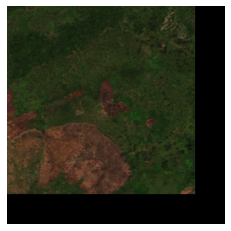

In [200]:
# visulizae any image patch 
image=np.moveaxis(image_list[35], 2, 0)

red= image[4, :, :]
green= image[2, :, :]
blue = image[1, :, :]
tcc= np.dstack((red, green, blue))
tcc=tcc*2.55

plt.imshow(tcc)
plt.axis("off")
plt.show()

In [ ]:
# if you need to import the model
from keras.models import load_model
model = load_model('./UNet_model.h5')

In [185]:
# classify each patch 
y_final=model.predict(image_list)
y_final_= np.argmax(y_final, axis=-1)

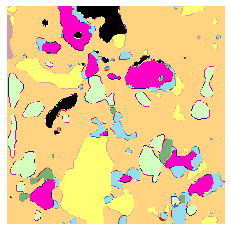

In [199]:
# visualize a patch
plt.imshow(y_final_[0])
plt.axis("off")
plt.show()

In [226]:
# merge image patches into a 'label map'
h_patches=math.ceil(data_img.shape[0]/patch_size)
w_patches=math.ceil(data_img.shape[1]/patch_size)
label_map= np.zeros((patch_size*h_patches, patch_size*w_patches), dtype=np.float32)

z=0
for i in range(0, data_img.shape[0]+1, 256) : 
  for j in range(0, data_img.shape[1]+1, 256):
    label_map[i:(i+patch_size), j:(j+patch_size)] = y_final_[z][:, :]
    z=z+1

# clipping off excess, if any
label_map= label_map[0:data_img.shape[0], 0:data_img.shape[1]]

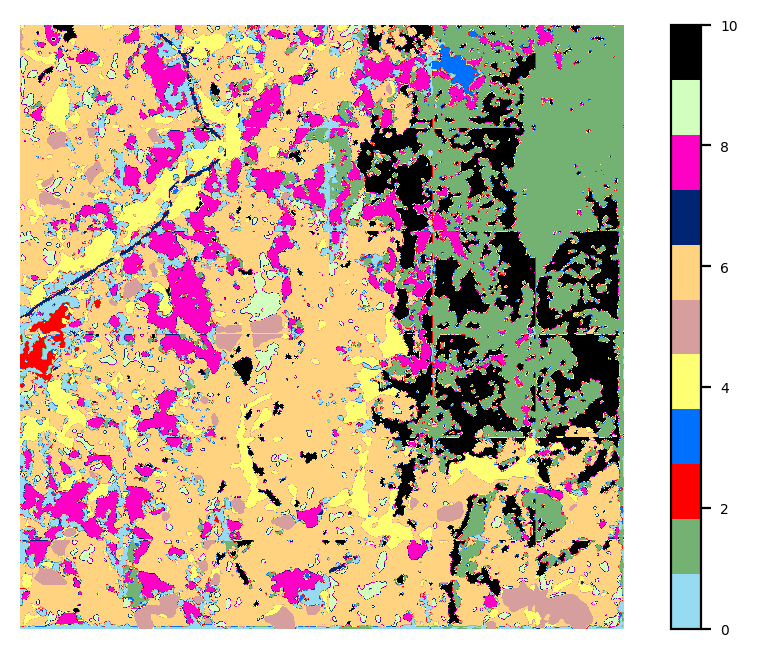

In [217]:
# show label map
plt.figure(dpi=200)
plt.imshow(label_map)
plt.colorbar()
plt.axis("off")
plt.show()

In [238]:
# saving the tif file

label_map= label_map.reshape((1, data_img.shape[0], data_img.shape[1]))
label_map= label_map.astype('float32') 
out_meta.update({"driver": "GTiff", 'dtype': 'float32', 'height':data_img.shape[0], 'width':data_img.shape[1]})

path='./label_map_UNet.tif' # change base path
with rasterio.open(path, "w", **out_meta) as dest:
    dest.write(label_map)

### 2. DNN

In [ ]:
!pip install rasterio

In [4]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from skimage import io
from keras.layers import Dense
from keras.losses import categorical_crossentropy
from keras.models import Sequential
from keras.layers.core import Dense,Activation,Flatten,Dropout
from keras.layers import BatchNormalization
from keras.layers import Input, Conv1D, MaxPooling1D, Concatenate
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.models import model_from_json
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import ModelCheckpoint
from keras.models import Model
import tensorflow as tf

In [ ]:
# import the data (pixel-level for SVM, RF, DNN; patch-one-hot-encoded for U-Net)
import numpy as np


# change base directory 

import os
path= r'./patch-one-hot' # change base dir
path= r'./pixel-level' 
path= r'./pixel-one-hot'

os.chdir(path)
x_train = np.load('./X_train.npy')
x_test = np.load('./X_test.npy')
y_train = np.load('./y_train.npy')
y_test = np.load('./y_test.npy')

#### 2.1. Defining Model

In [5]:
lr= 0.007
dr= 0.23
epochs=200
bt= 48

In [6]:
# for tensorflow 2.5
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(32, activation=tf.nn.relu),
  tf.keras.layers.Dense(64, activation=tf.nn.relu),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(128, activation=tf.nn.relu),
  tf.keras.layers.Dense(256, activation=tf.nn.relu),
  tf.keras.layers.Dense(1024, activation=tf.nn.relu),
  tf.keras.layers.Dropout(dr),
  tf.keras.layers.Dense(11, activation=tf.nn.softmax)
])

In [7]:
# Compile the model with the specified loss function.
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [8]:
# Fit the model to the training data.
history= model.fit(x=x_train, y=y_train, epochs=epochs, batch_size=bt,validation_split=0.2)

Epoch 1/10
12015/12015 [==============================] - 48s 4ms/step - loss: 0.8976 - accuracy: 0.6848 - val_loss: 1.7234 - val_accuracy: 0.4997
Epoch 2/10
12015/12015 [==============================] - 45s 4ms/step - loss: 0.8616 - accuracy: 0.6973 - val_loss: 1.5754 - val_accuracy: 0.5604
Epoch 3/10
12015/12015 [==============================] - 44s 4ms/step - loss: 0.8539 - accuracy: 0.7010 - val_loss: 1.7667 - val_accuracy: 0.4724
Epoch 4/10
12015/12015 [==============================] - 46s 4ms/step - loss: 0.8597 - accuracy: 0.6993 - val_loss: 1.0225 - val_accuracy: 0.6595
Epoch 5/10
12015/12015 [==============================] - 44s 4ms/step - loss: 0.8499 - accuracy: 0.7028 - val_loss: 1.4784 - val_accuracy: 0.5346
Epoch 6/10
12015/12015 [==============================] - 44s 4ms/step - loss: 0.8459 - accuracy: 0.7049 - val_loss: 1.2149 - val_accuracy: 0.5951
Epoch 7/10
12015/12015 [==============================] - 45s 4ms/step - loss: 0.8442 - accuracy: 0.7055 - val_loss: 1

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                544       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              263168    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0

#### 2.2. Visualizing Loss Curves

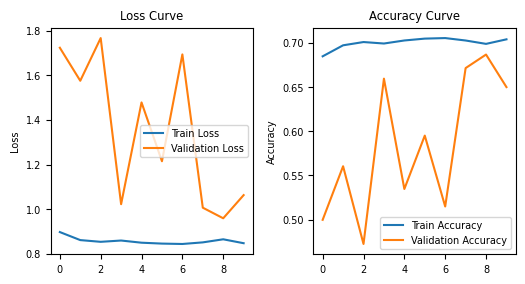

In [10]:
# Plot the loss curve

#'family' : 'Arial',
font = {
        'weight' : 'normal',
        'size'   : 7}

matplotlib.rc('font', **font)

fig, ax = plt.subplots(1, 2, figsize=(6, 3), dpi=100)

ax[0].plot(history.history['loss'], label='Train Loss')
ax[0].plot(history.history['val_loss'], label='Validation Loss')
ax[0].set_title('Loss Curve')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(history.history['accuracy'], label='Train Accuracy')
ax[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[1].set_title('Accuracy Curve')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.subplots_adjust(wspace=0.3)
#fig.savefig(fname="Accuracy-Loss_Curve.png", dpi=300, bbox_inches='tight')
plt.show()

#### Hyperparameter Optimization

In [ ]:
 
batches = [32,48,64,96,128]
learn_rates = [0.0005,0.003,0.005,0.007,0.009,0.05,0.07,0.09,0.01]
dropout_rates = [0.20,0.23,0.25,0.27,0.30,0.35]


In [ ]:
epochs=100
df2 = pd.DataFrame(columns=['batch', 'learn', 'dropout', 'Test_Acc']) 

for bt in batches:
    for lr in learn_rates:
        for dr in dropout_rates:
            print('batch_size: '+str(bt),'learn_rate: '+str(lr),'dropout_rate: '+str(dr))
            

            # Fit the model
            hist = model.fit(x_train, y_train, epochs=epochs, batch_size=bt, validation_split=0.30, callbacks=callbacks_list, verbose=0)         


            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy', 
                          metrics=['accuracy'])
            y_pred = model.predict(x_test)
            y_pred_ = np.argmax(y_pred, axis=1)
            y_test_ = np.argmax(y_test, axis=1)

            OA= accuracy_score(y_test_, y_pred_)
      
            #if OA > 0.85: 
            model.save('./results/hyper_/CNN_hyperaramter_model_{0}_.h5'.format(accuracy_score(y_test_, y_pred_)))

            df2= df2.append({ 'batch': bt, 'learn': lr, 'dropout': dr,  'Test_Acc':accuracy_score(y_test_, y_pred_)}, ignore_index= True)

#### 2.3. Prediction & Evaluation

In [11]:
# training prediction
y_pred_train = model.predict(x_train)
y_pred = model.predict(x_test)

# testing prediction
y_pred_train_ = np.argmax(y_pred_train, axis=1)
y_pred_ = np.argmax(y_pred, axis=1)

# reverse one-hot encoding for y_train and y_test
y_train_ = np.argmax(y_train, axis=1)
y_test_ = np.argmax(y_test, axis=1)

In [12]:
# training metrics
train_acc = accuracy_score(y_train_,y_pred_train_)
print('Model Training accuracy: %.3f' % train_acc)
print('model training kappa: ', cohen_kappa_score(y_train_, y_pred_train_))

# testing metrics
test_acc= accuracy_score(y_test_,y_pred_)
print('Model Testing accuracy: %.3f' % test_acc)
print('model Testing kappa: ', cohen_kappa_score(y_test_, y_pred_))

Model Training accuracy: 0.670
model training kappa:  0.5944284236014891
Model Testing accuracy: 0.682
model Testing kappa:  0.6137227110274386


In [13]:
cm= confusion_matrix(y_pred=y_pred_, y_true=y_test_)

In [270]:
# save the model
model.save('./DNN_model.h5')

### 3. SVM

In [247]:
#import models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# import the data (pixel-level for SVM, RF, DNN; patch-one-hot-encoded for U-Net)
import numpy as np


# change base directory 

import os
path= r'./patch-one-hot' # change base dir
path= r'./pixel-level' 
path= r'./pixel-one-hot'

os.chdir(path)
x_train = np.load('./X_train.npy')
x_test = np.load('./X_test.npy')
y_train = np.load('./y_train.npy')
y_test = np.load('./y_test.npy')

#### 3.1. Defining Model 

In [ ]:
model = SVC()
### Define parameters for tuning and optimization
C = [0.1, 1, 10, 100, 1000]
gamma = [1, 0.1, 0.01, 0.001, 0.0001]

#C = [2**-10,2**-9,2**-8,2**-7,2**-6,2**-5,2**-4,2**-3,2**-2,2**-1,2**0,2**1,2**2,2**3,2**4,2**5,2**6,2**7,2**8,2**9,2**10,2**11,2**12,2**13,2**14,2**15,2**16,2**17,2**18,2**19,2**20,2**21,2**22,2**23,2**24,2**25,2**26,2**27]
#gamma = [2**-15,2**-14,2**-13,2**-12,2**-11,2**-10,2**-9,2**-8,2**-7,2**-6,2**-5,2**-4,2**-3,2**-2,2**-1,2**0,2**1,2**2,2**3,2**5,2**6,2**7,2**8,2**9,2**10,2**11,2**12,2**13,2**14,2**15]

### Model Training through K-Fold Cross validation and GridSearch Strategies
param_grid = {'C':C,  
              'gamma':gamma, 
              'kernel': ['rbf','linear']}

grid_model = GridSearchCV(model, param_grid, cv=5,verbose = 1,n_jobs = -1)
grid_model.fit(x_train,y_train)

#### 3.2. Prediction & Evaluation

In [ ]:
# Classification Model Validation
# Get Training metrics
y_pred_train = grid_model.predict(x_train)
print('Mode Training accuracy: %f' % accuracy_score(y_train, y_pred_train))
print('Model Training kappa: %f' % cohen_kappa_score(y_train, y_pred_train))

# Get Testing/validation metrics
y_pred_test = grid_model.predict(x_test)
print('Mode Testing accuracy: %f' % accuracy_score(y_test, y_pred_test))
print('Model Testing kappa: %f' % cohen_kappa_score(y_test, y_pred_test))


In [35]:
cm= confusion_matrix(y_test, y_pred_test)

In [ ]:
# saving the model
joblib.dump(grid_model.best_params_, 'SVM_model.pkl', compress = 1)

### 4. RF

In [ ]:
#import models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib

In [ ]:
# import the data (pixel-level for SVM, RF, DNN; patch-one-hot-encoded for U-Net)
import numpy as np


# change base directory 

import os
path= r'./patch-one-hot' # change base dir
path= r'./pixel-level' 
path= r'./pixel-one-hot'

os.chdir(path)
x_train = np.load('./X_train.npy')
x_test = np.load('./X_test.npy')
y_train = np.load('./y_train.npy')
y_test = np.load('./y_test.npy')

#### 4.1. Defining Model

In [ ]:
model = RandomForestClassifier(random_state=0) #Initialize with whatever parameters you want to
# Define parameters for tuning
number_of_trees = np.linspace(1,500,num=51).tolist()
number_of_trees = [int(i) for i in number_of_trees]
max_features = ['auto','sqrt','log2']
param_grid = {
                 'n_estimators': number_of_trees,
                 'max_features': max_features,
                 'criterion' :['gini', 'entropy']
             }
# K-Fold Cross validation for parameters tunning
grid_model = GridSearchCV(model, param_grid,cv=3,verbose = 3,n_jobs=-1) # Extract best parameters using gridsearch_CV
grid_model.fit(x_train, y_train) # fit the model to training set data by using the best model parameters

#### 4.2. Prediction & Evaluation


In [ ]:
# Classification Model Validation
# Get Training metrics
y_pred_train = grid_model.predict(x_train)
print('Mode Training accuracy: %f' % accuracy_score(y_train, y_pred_train))
print('Model Training kappa: %f' % cohen_kappa_score(y_train, y_pred_train))


# Get Testing/validation metrics
y_pred_test = grid_model.predict(x_test)
print('Mode Testing accuracy: %f' % accuracy_score(y_test, y_pred_test))
print('Model Testing kappa: %f' % cohen_kappa_score(y_test, y_pred_test))


In [ ]:
cm= confusion_matrix(y_test, y_pred_test)

In [ ]:
# saving the model
joblib.dump(grid_model.best_params_, 'RF_model.pkl', compress = 1)

## Saving Common Results


1. saving confusion matrix
2. saving the classified map


### Confusion Matrix

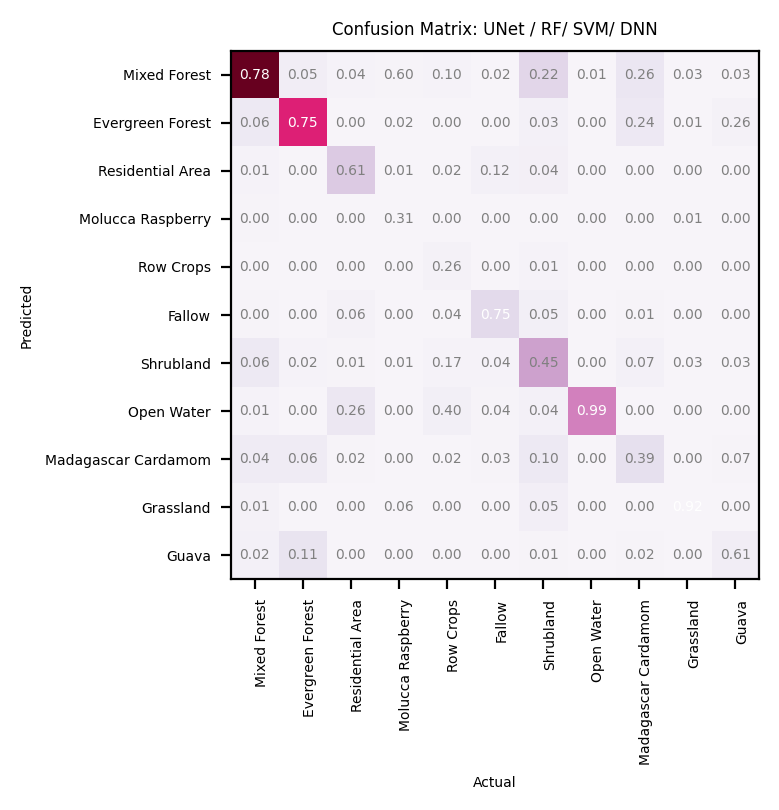

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

order= [1,2,3,4,5,6,7,8,9,10,11]
class_names=['Mixed Forest','Evergreen Forest','Residential Area','Molucca Raspberry','Row Crops','Fallow',
             'Shrubland','Open Water', 'Madagascar Cardamom','Grassland','Guava']
cm= pd.DataFrame(data=cm, index=order, columns=order)
rf_cm_percent_test = pd.DataFrame(index=order, columns=order)

for i in range(0,11):
  for j in range(0, 11):
    rf_cm_percent_test.iloc[i,j]=(cm.iloc[i,j]/cm[order[j]].sum())

fig, ax = plt.subplots(dpi=200)
im = ax.imshow(cm, cmap='PuRd') 

font = {'weight' : 'normal', 'size'   : 5}
matplotlib.rc('font', **font)

# We want to show all ticks...
ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
# ... and label them with the respective list entries
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(class_names)):
    for j in range(len(class_names)):
      if rf_cm_percent_test.iloc[i, j]>0.7:
        text = ax.text(j, i, format(rf_cm_percent_test.iloc[i, j], '.2f'), ha="center", va="center", color="w")
      else: 
        text = ax.text(j, i, format(rf_cm_percent_test.iloc[i, j], '.2f'), ha="center", va="center", color="grey")

ax.set_title("Confusion Matrix: UNet / RF/ SVM/ DNN")
ax.set_ylabel("Predicted")
ax.set_xlabel("Actual")
fig.tight_layout()
#plt.savefig(r'.\confusion_matrix_2_6.png')
plt.show()

### Classification Map (SVM, RF, DNN)

In [5]:
# importing the 16 band WV-3 imagery
import rasterio
image_path= './data_img.tif' # import the image; change base dir
src= rasterio.open(image_path)
image_unmoved=src.read()
out_meta = src.profile
src.close()

data_img= np.moveaxis(image_unmoved, 0, 2) # format should be (rows x cols x channels)

ModuleNotFoundError: No module named 'rasterio'

In [26]:
label_map.shape

(1, 1501, 1501)

In [20]:
img_flat = data_img.reshape(data_img.shape[0]*data_img.shape[1], data_img.shape[2]) # flatening
pred_img = model.predict(img_flat)

# for DNN
pred_img = np.argmax(pred_img, axis=1)

# Save the predicted labels as a map
label_map = np.reshape(pred_img,(data_img.shape[0],data_img.shape[1])) # Convert 1D label to 2D map

<function matplotlib.pyplot.show>

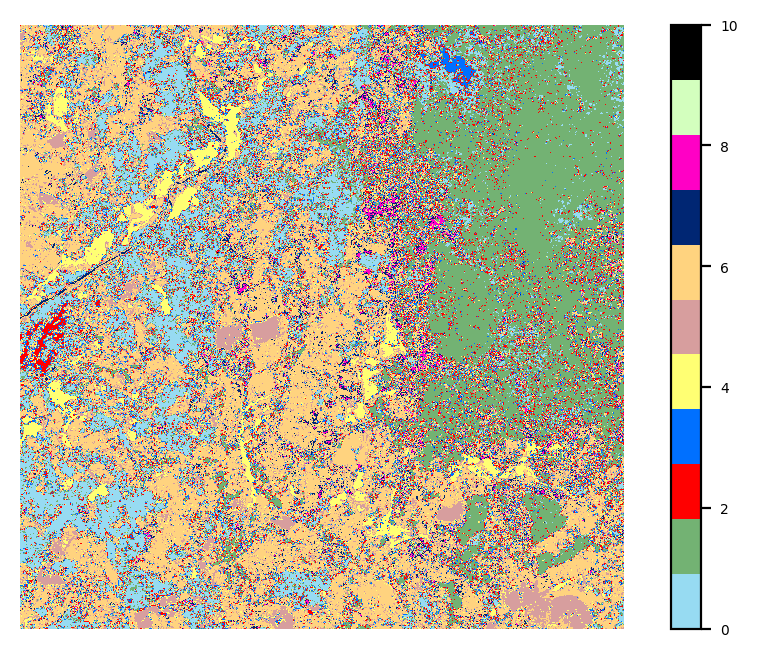

In [23]:
# visualize label map
plt.figure(dpi=200)
plt.imshow(label_map)
plt.colorbar()
plt.axis("off")
plt.show

In [27]:
# saving the tif file

label_map= label_map.reshape((1, data_img.shape[0], data_img.shape[1]))
label_map= label_map.astype('float32') 
out_meta.update({"driver": "GTiff", 'dtype': 'float32', 'height':data_img.shape[0], 'width':data_img.shape[1], 'count':1})

path='./label_map_DNN.tif'
with rasterio.open(path, "w", **out_meta) as dest:
    dest.write(label_map)

## Accuracy Assesment of classified maps

In [30]:
from skimage import io
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score

# function produces overall accuracy, kappa coeff and confusion matrix
def get_accuracy_metrics(pred_img_path, true_img_path, label=(1,2,3,4,5,6,7,8,9,10, 11)):
   
    # reading the predicted label map and the true image
    y_pred_img=io.imread(pred_img_path) # predicted
    y_true_img=io.imread(true_img_path) # true
   
    # reshaping to be a vector
    y_pred= y_pred_img.reshape(-1, )
    y_true= y_true_img.reshape(-1, )
   
    # getting the confusion matrix
    cm= confusion_matrix(y_true, y_pred, labels= label)
   
    # putting the confusion matrix in a dataframe (then save the df- manually or through code)
    df= pd.DataFrame(data=cm)
   
    # getting accuracy

    TA= accuracy_score(y_true,y_pred)
   
    # getting kappa
    kappa= cohen_kappa_score(y_true, y_pred,labels=label )
   
    return df, TA, kappa


'    diagonal_sum= 0\n    for i in range(0,11):    \n        diagonal_sum= df.iloc[i,i]+ diagonal_sum\n       \n    TA= diagonal_sum/10952\n'

In [31]:
true_img_path= './Bet_LandCover_2020.tif'
pred_img_path= './label_map_UNet.tif'
df_cm, TA, kappa= get_accuracy_metrics(pred_img_path, true_img_path)


In [32]:
TA

0.5550623368564861

In [33]:
kappa

0.5263868053689476

In [35]:
df_cm

,0,1,2,3,4,5,6,7,8,9,10
0,327591,26,189,2371,44,76323,213,23697,3582,207536,0
1,6,6736,2,2434,4123,1559,445,13,9,3,0
2,309,0,5988,17,5,1072,5,301,1907,0,0
3,94,245,5,84312,941,18868,1761,331,352,971,0
4,11,1867,3,4054,41813,4821,318,32,5,0,0
5,12598,1733,377,47379,8937,594361,1134,19876,42418,8835,0
6,2,201,0,1046,28,84,4062,2,6,22,0
7,18951,4,58,1372,270,43517,80,43052,343,5410,0
8,34,0,6,2,3,636,0,0,1206,2,0
9,5556,6,0,1056,2,13045,15,813,47,33282,0
